# How to Access the Hydrology Data Rods Time Series API Using Python

### Overview

This notebook describes accessing the [Hydrology Data Rods Time Series API](https://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Data%20Rods) using Python. It queries a grid nearest Newton, IL, and queries two months of hourly NLDAS hourly surface and top 0-100cm soil precipitation totals. These variables are then plotted using Matplotlib.

### Prerequisites

This notebook was written using Python 3.9, and uses these libraries and files:

- [requests](https://docs.python-requests.org/en/latest/) (version 2.22.0 or later)
- [Pandas](https://pandas.pydata.org/docs/index.html)
- [Matplotlib](https://matplotlib.org/)
- [Seaborn](https://seaborn.pydata.org/) (optional, used for our plot theme)


#### Import modules

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import urllib
import urllib.parse as urlp
import io
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### Define functions that create the URLs for calling the time series service, and parses their ASCII text


In [2]:
def get_time_series(start_date,end_date,latitude,longitude,variable):
    """
    Calls the data rods service to get a time series
    """
    base_url = "https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi"
    query_parameters = {
        "variable": variable,
        "type": "asc2",
        "location": f"GEOM:POINT({longitude}, {latitude})",
        "startDate": start_date,
        "endDate": end_date,
    }
    full_url = base_url+"?"+ \
         "&".join(["{}={}".format(key,urlp.quote(query_parameters[key])) for key in query_parameters])
    print(full_url)
    iteration = 0
    done = False
    while not done and iteration < 5:
        r=requests.get(full_url)
        if r.status_code == 200:
            done = True
        else:
            iteration +=1
    
    if not done:
        raise Exception(f"Error code {r.status_code} from url {full_url} : {r.text}")
    
    return r.text

def parse_time_series(ts_str):
    """
    Parses the response from data rods.
    """
    lines = ts_str.split("\n")
    parameters = {}
    for line in lines[2:11]:
        key,value = line.split("=")
        parameters[key] = value
    
    
    df = pd.read_table(io.StringIO(ts_str),sep="\t",
                       names=["time","data"],
                       header=10,parse_dates=["time"])
    return parameters, df

#### Call the time series data rods service with our requested URLs

This query will return the center point of the closest grid, which is actually at 38.9375, -88.1875:

https://goo.gl/maps/1seZXh8RfFVz2b8a8

In [3]:
df_precip = parse_time_series(
            get_time_series(
                start_date="2022-07-01T00", 
                end_date="2022-09-01T00",
                latitude=38.89,
                longitude=-88.18,
                variable="NLDAS2:NLDAS_FORA0125_H_v2.0:Rainf"
            )
        )

df_soil = parse_time_series(
            get_time_series(
                start_date="2022-07-01T00", 
                end_date="2022-09-01T00",
                latitude=38.89,
                longitude=-88.18,
                variable="NLDAS2:NLDAS_NOAH0125_H_v2.0:SoilM_0_100cm"
          )
        )

df_soil[1]['data']

https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_FORA0125_H_v2.0%3ARainf&type=asc2&location=GEOM%3APOINT%28-88.18%2C%2038.89%29&startDate=2022-07-01T00&endDate=2022-09-01T00
https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_NOAH0125_H_v2.0%3ASoilM_0_100cm&type=asc2&location=GEOM%3APOINT%28-88.18%2C%2038.89%29&startDate=2022-07-01T00&endDate=2022-09-01T00


0       266.482
1       266.488
2       266.520
3       266.539
4       266.558
         ...   
1484    267.478
1485    267.062
1486    266.777
1487    266.662
1488    266.668
Name: data, Length: 1489, dtype: float64

#### Combine data into a single dataframe

In [4]:
d = {'time': pd.to_datetime(df_precip[1]['time'], unit='s'), 
    'Rainf': df_precip[1]['data'], 
    'SoilM_0_100cm': df_soil[1]['data']}
    
df = pd.DataFrame(data=d)
df.head()

,time,Rainf,SoilM_0_100cm
0,2022-07-01 00:00:00,0.0,266.482
1,2022-07-01 01:00:00,0.0,266.488
2,2022-07-01 02:00:00,0.0,266.520
3,2022-07-01 03:00:00,0.0,266.539
4,2022-07-01 04:00:00,0.0,266.558


#### Plot using Matplotlib

''

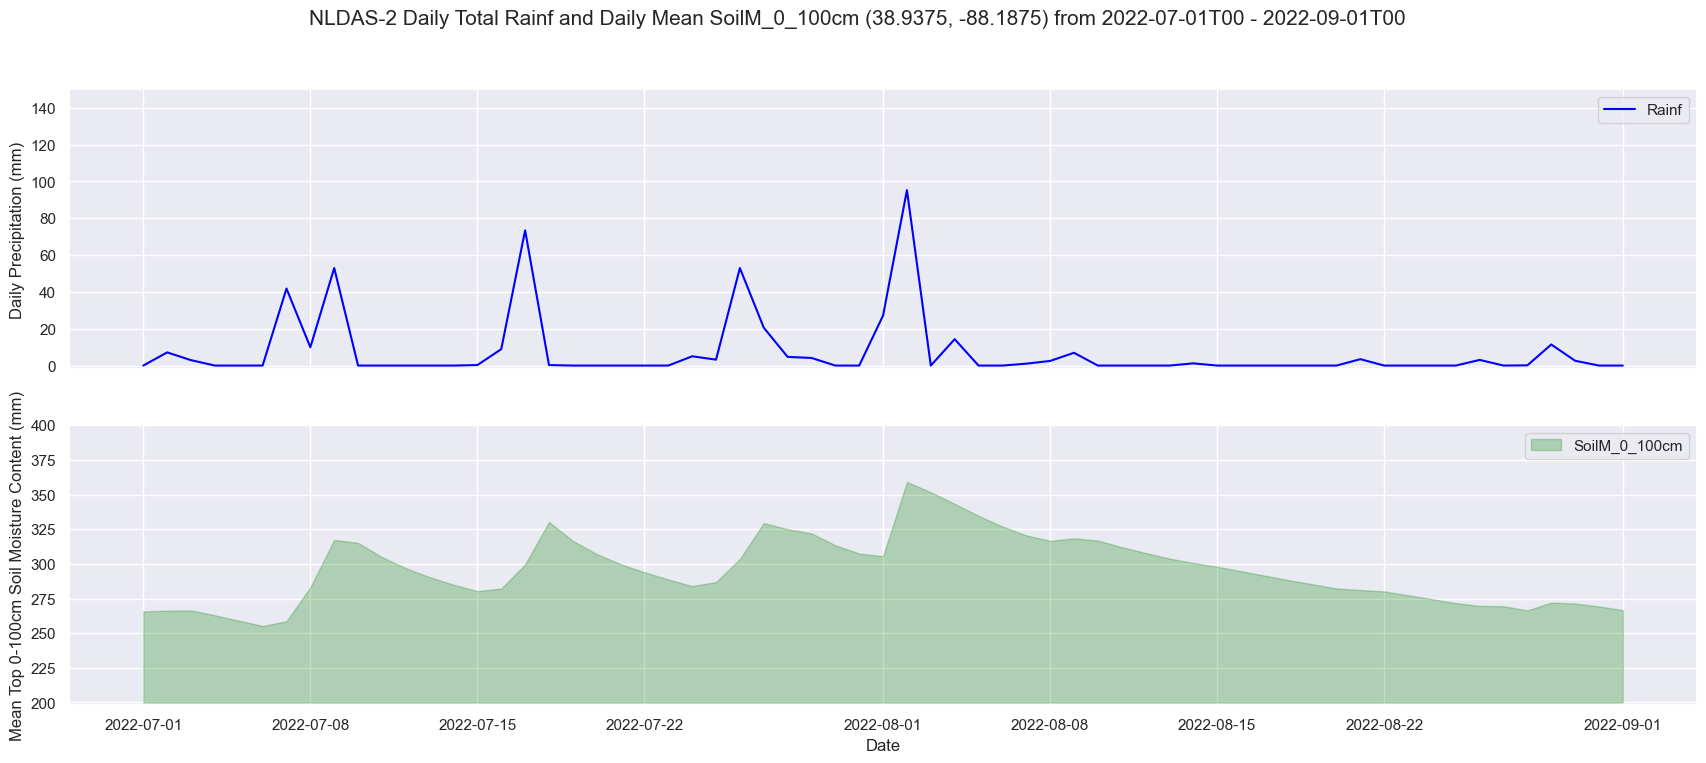

In [5]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(21, 8), sharex=True)

# Aggregate over days
daily_precip = df[['time', 'Rainf']].groupby(pd.Grouper(key='time', freq='1D')).sum().reset_index()
daily_soil = df[['time', 'SoilM_0_100cm']].groupby(pd.Grouper(key='time', freq='1D')).mean().reset_index()

ax1.plot(daily_precip["time"], daily_precip["Rainf"], color="blue")
ax1.set_ylim(-2, 150)
ax1.legend(["Rainf"])
ax1.set_ylabel("Daily Precipitation (mm)")

ax2.fill_between(daily_soil["time"], 200, daily_soil["SoilM_0_100cm"], color="green", alpha=0.25)
ax2.set_ylim(198, 400)
ax2.legend(["SoilM_0_100cm"])
ax2.set_ylabel("Mean Top 0-100cm Soil Moisture Content (mm)")
ax2.set_xlabel("Date")

fig.suptitle("NLDAS-2 Daily Total Rainf and Daily Mean SoilM_0_100cm (38.9375, -88.1875) from 2022-07-01T00 - 2022-09-01T00", size=15)
  
;